In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

plt.style.use('seaborn')
%matplotlib inline

## GMM SCORES

In [10]:
cm_score = pd.read_csv('cm_score_18-march.csv')
cm_score

,AUDIO_FILE_NAME,SCORE,Prediction,SPEAKER_ID,ENVIRONMENT_ID,ATTACK_ID,KEY,Stat
0,LA_E_7338223,-1827.310830,spoof,LA_0014,-,A07,spoof,True
1,LA_E_9469091,-2782.358037,spoof,LA_0033,-,A10,spoof,True
2,LA_E_1788336,-1716.014268,spoof,LA_0035,-,A07,spoof,True
3,LA_E_6616286,-0.124108,spoof,LA_0009,-,A19,spoof,True
4,LA_E_1222387,-2280.597529,spoof,LA_0013,-,A07,spoof,True
...,...,...,...,...,...,...,...,...
17868,LA_E_8797106,20.822824,bonafide,LA_0055,-,-,bonafide,True
17869,LA_E_3394900,204.465933,bonafide,LA_0067,-,-,bonafide,True
17870,LA_E_4215246,11.243683,bonafide,LA_0064,-,-,bonafide,True
17871,LA_E_9153255,112.628749,bonafide,LA_0039,-,-,bonafide,True


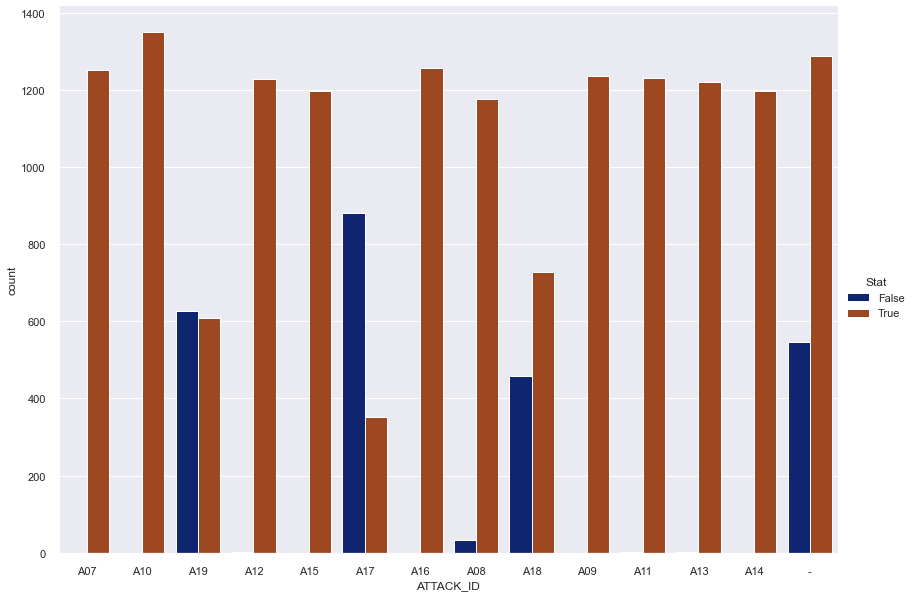

In [12]:
#sns.set(rc={'figure.figsize':(20, 8)})
ax = sns.catplot(x="ATTACK_ID", kind="count", hue="Stat",  data=cm_score,palette=sns.color_palette('dark', n_colors=3),height=8.27, aspect=11.7/8.27)


## SVM Scores

In [15]:
svm = pickle.load(open('/Users/asimadnan/Desktop/Mres/Experiments/Models/svm_model.svm','rb'))

In [29]:
eval_data_labels = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt'
eval_data_path = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_eval/mfcc_v1.csv'

eval_data = pd.read_csv(eval_data_path, delimiter = ",", header=None)
eval_labels =  pd.read_csv(eval_data_labels, delimiter = " ", header=None)

In [21]:
X_eval = eval_data.drop([0,601], axis=1)
y_eval = eval_data[[601]]

y_score = svm.decision_function(X_eval)


In [20]:
fpr, tpr, thresholds = roc_curve(y_eval, y_score,pos_label='spoof')
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
print('EER: ',eer)

EER:  0.14885496183366498


In [35]:
eval_data['Desc Score'] = y_score
eval_data.columns

Index([           0,            1,            2,            3,            4,
                  5,            6,            7,            8,            9,
       ...
                593,          594,          595,          596,          597,
                598,          599,          600,          601, 'Desc Score'],
      dtype='object', length=603)

In [41]:
eval_scores = eval_data[[0,601,'Desc Score']]
eval_scores.columns = ['AUDIO_FILE_NAME','Key','SCORE']
eval_scores

,AUDIO_FILE_NAME,Key,SCORE
0,LA_E_7338223,spoof,2.037251
1,LA_E_9469091,spoof,2.673685
2,LA_E_1788336,spoof,2.547469
3,LA_E_6616286,spoof,0.920930
4,LA_E_1222387,spoof,3.153588
...,...,...,...
17868,LA_E_2967658,spoof,1.930929
17869,LA_E_7697219,spoof,2.075088
17870,LA_E_6825673,spoof,2.990278
17871,LA_E_7894529,spoof,2.402580


In [40]:
eval_labels.columns = ['SPEAKER_ID','AUDIO_FILE_NAME','ENVIRONMENT_ID','ATTACK_ID','KEY']

In [43]:
final_score = pd.merge(eval_scores, eval_labels, on="AUDIO_FILE_NAME")
final_score

,AUDIO_FILE_NAME,Key,SCORE,SPEAKER_ID,ENVIRONMENT_ID,ATTACK_ID,KEY
0,LA_E_7338223,spoof,2.037251,LA_0014,-,A07,spoof
1,LA_E_9469091,spoof,2.673685,LA_0033,-,A10,spoof
2,LA_E_1788336,spoof,2.547469,LA_0035,-,A07,spoof
3,LA_E_6616286,spoof,0.920930,LA_0009,-,A19,spoof
4,LA_E_1222387,spoof,3.153588,LA_0013,-,A07,spoof
...,...,...,...,...,...,...,...
17868,LA_E_2967658,spoof,1.930929,LA_0045,-,A16,spoof
17869,LA_E_7697219,spoof,2.075088,LA_0031,-,A15,spoof
17870,LA_E_6825673,spoof,2.990278,LA_0042,-,A08,spoof
17871,LA_E_7894529,spoof,2.402580,LA_0042,-,A16,spoof


In [47]:
final_score.loc[final_score['SCORE'] > 0, 'Prediction'] = 'spoof'
final_score.loc[final_score['SCORE'] < 0, 'Prediction'] = 'bonafide'

final_score.loc[final_score['Prediction'] == cm_score['KEY'], 'Stat'] = True
final_score.loc[final_score['Prediction'] != cm_score['KEY'], 'Stat'] = False

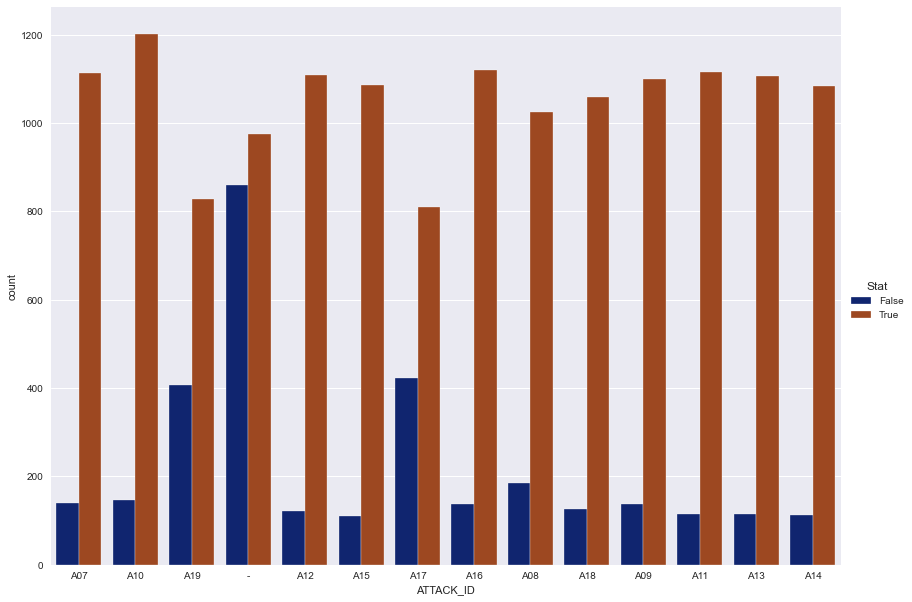

In [48]:
ax = sns.catplot(x="ATTACK_ID", kind="count", hue="Stat",  data=final_score,palette=sns.color_palette('dark', n_colors=3),height=8.27, aspect=11.7/8.27)
